## Loading the libraries

In [9]:
import numpy as np 
import pandas as pd
import anndata as ad
from scipy import sparse
import matplotlib.pyplot as plt
#!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 #The torch version needed for Helical

## Finding ALS genes

- **Most well-known ALS genes (OR > 10)**: _C9orf72, SOD1, TARDBP, FUS_

- **Other ALS genes with strong effect size (OR > 10)**: _TBK1, TUBA4A, UBQLN2, VCP, OPTN, NEK1_

- **Rare variants with moderate effect size (1.2 < OR < 10)**: _TIA1, ATXN2, SQSTM1, ANG, PRPH, PFN1, SETX, SPG11, FIG4, DCTN1, ALS2, VAPB, GLT8D1, NEFH, CFAP410, CHMP2B, CHCHD10, KIF5A_

- **Rare variants with small effect size (OR < 1.2)**: _CCNF_ 

- **Rare variants with unknown effect size**: _ERBB4, HNRNPA1, HNRNPA2B1, MATR3, SIGMAR1, SPTLC1_

- **Common variants with small effect size**: _UNC13A, ERGIC1, SLC9A8, SCFD1, RPSA, COG3, GPX3, PTPRN2, HLA_

**Reference**: Nijs, M., & Van Damme, P. (2024). The genetics of amyotrophic lateral sclerosis. _Current opinion in neurology_, 37(5), 560–569. https://doi.org/10.1097/WCO.0000000000001294

In [10]:
genes = ["C9orf72","SOD1","TARDBP","FUS",
         "TBK1","TUBA4A","UBQLN2","VCP","OPTN","NEK1",
         "TIA1","ATXN2","SQSTM1","ANG","PRPH","PFN1","SETX","SPG11","FIG4","DCTN1","ALS2","VAPB","GLT8D1","NEFH","CFAP410","CHMP2B","CHCHD10","KIF5A",
         "CCNF",
         "ERBB4","HNRNPA1","HNRNPA2B1","MATR3","SIGMAR1","SPTLC1",
         "UNC13A","ERGIC1","SLC9A8","SCFD1","RPSA","COG3","GPX3","PTPRN2","HLA"]

## Loading in the dataset

In [11]:
adata = ad.read_h5ad("/Users/ali/Downloads/counts_combined_filtered_BA4_sALS_PN.h5ad")

## Subsetting the genes

Now, we will check how many of these genes are present in our data. We will take out any genes that are not present and stratify the rest by categories. 

In [12]:
var_upper = pd.Series(adata.var_names.values, index=adata.var_names.str.upper())
q = pd.DataFrame({"gene": genes})
q["gene_up"] = q["gene"].str.upper()
q["present"] = q["gene_up"].isin(var_upper.index)
q["matched_var_name"] = q["gene_up"].map(var_upper).where(q["present"])
present = q[q["present"]]["matched_var_name"].tolist()
missing = q[~q["present"]]["gene"].tolist()

print("ALS genes present:", len(present))
print(sorted(present))
print("ALS genes missing:", len(missing))
print(sorted(missing))

ALS genes present: 43
['ALS2', 'ANG', 'ATXN2', 'C9orf72', 'CCNF', 'CFAP410', 'CHCHD10', 'CHMP2B', 'COG3', 'DCTN1', 'ERBB4', 'ERGIC1', 'FIG4', 'FUS', 'GLT8D1', 'GPX3', 'HNRNPA1', 'HNRNPA2B1', 'KIF5A', 'MATR3', 'NEFH', 'NEK1', 'OPTN', 'PFN1', 'PRPH', 'PTPRN2', 'RPSA', 'SCFD1', 'SETX', 'SIGMAR1', 'SLC9A8', 'SOD1', 'SPG11', 'SPTLC1', 'SQSTM1', 'TARDBP', 'TBK1', 'TIA1', 'TUBA4A', 'UBQLN2', 'UNC13A', 'VAPB', 'VCP']
ALS genes missing: 1
['HLA']


In [13]:
well_known = ["C9orf72","SOD1","TARDBP","FUS"]
top_10 = ["C9orf72","SOD1","TARDBP","FUS", "TBK1","TUBA4A","UBQLN2","VCP","OPTN","NEK1"]
rare_variants = ["TIA1","ATXN2","SQSTM1","ANG","PRPH","PFN1","SETX","SPG11","FIG4","DCTN1","ALS2","VAPB","GLT8D1","NEFH","CFAP410","CHMP2B","CHCHD10","KIF5A", "CCNF",]
unknown_effects = ["ERBB4","HNRNPA1","HNRNPA2B1","MATR3","SIGMAR1","SPTLC1"]
common_variants = ["UNC13A","ERGIC1","SLC9A8","SCFD1","RPSA","COG3","GPX3","PTPRN2"]
all_genes = present

## Function to induce _in silico_ perturbations

In [14]:
def simulate_perturbation(
    path,
    genes,
    mode="up",
    fold_change=2.0,
    frac_cells=1.0,
    by_group_key=None,
    group_values=None,
    layer="X",
    out_layer=None,
    rng_seed=42,
):
    
    print(f"Simulating {mode} regulation of {genes} in {frac_cells*100:.1f}% of cells")

    print(f"Loading data from: {path}")

    A = ad.read_h5ad(path)
    if layer == "X":
        X = A.X
    else:
        if layer not in A.layers:
            raise KeyError(f"Layer '{layer}' not found")
        X = A.layers[layer]
    if out_layer is not None:
        if out_layer == "X":
            if sparse.issparse(X):
                A.X = X.copy()
            else:
                A.X = np.array(X, copy=True)
            X = A.X
        else:
            if sparse.issparse(X):
                A.layers[out_layer] = X.copy()
            else:
                A.layers[out_layer] = np.array(X, copy=True)
            X = A.layers[out_layer]
    cell_idx = np.arange(A.n_obs)
    if by_group_key and group_values:
        col = A.obs[by_group_key].astype(str).str.lower()
        want = set(v.lower() for v in group_values)
        mask = col.isin(want).values
        cell_idx = np.where(mask)[0]
    if cell_idx.size == 0:
        raise ValueError("No cells matched the requested group")
    n_perturb = int(np.ceil(frac_cells * len(cell_idx)))
    rng = np.random.default_rng(rng_seed)
    chosen = rng.choice(cell_idx, size=n_perturb, replace=False)
    gene_ix = [A.var_names.get_loc(g) for g in genes if g in A.var_names]
    if not gene_ix:
        raise ValueError("None of the specified genes were found in var_names")
    scale = float(fold_change) if mode == "up" else 1.0 / float(fold_change)
    if sparse.issparse(X):
        X = X.tocsr(copy=False)
        gi = np.array(gene_ix, dtype=np.int32)
        for i in chosen:
            a, b = X.indptr[i], X.indptr[i + 1]
            cols = X.indices[a:b]
            m = np.isin(cols, gi, assume_unique=False)
            if m.any():
                X.data[a:b][m] = np.rint(X.data[a:b][m] * scale)
        X.eliminate_zeros()
        if out_layer is None:
            if layer == "X":
                A.X = X
            else:
                A.layers[layer] = X
        else:
            if out_layer == "X":
                A.X = X
            else:
                A.layers[out_layer] = X
    else:
        idx = np.ix_(chosen, gene_ix)
        X[idx] = np.rint(X[idx] * scale)
        np.clip(X, 0, None, out=X)
        if out_layer is None:
            if layer == "X":
                A.X = X
            else:
                A.layers[layer] = X
        else:
            if out_layer == "X":
                A.X = X
            else:
                A.layers[out_layer] = X
    A.obs["perturbed"] = A.obs_names.isin(A.obs_names[chosen])
    A.obs["perturb_mode"] = mode

    print(f"Finished simulation for {genes} in {frac_cells*100:.1f}% of cells")
    print(f"Returning modified AnnData object")
    return A

## Figuring out targets

We can build heatmaps of ALS-implicated genes and see which ones show strong correlation with other genes. Those heatmaps can inform us of potential targets

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/8m/dxckcnm51258h_69j8ctn3c40000gn/T/ipykernel_7217/1501269842.py:34: RuntimeWarning: Mean of empty slice
  mean_abs = np.nanmean(C_abs, axis=0)


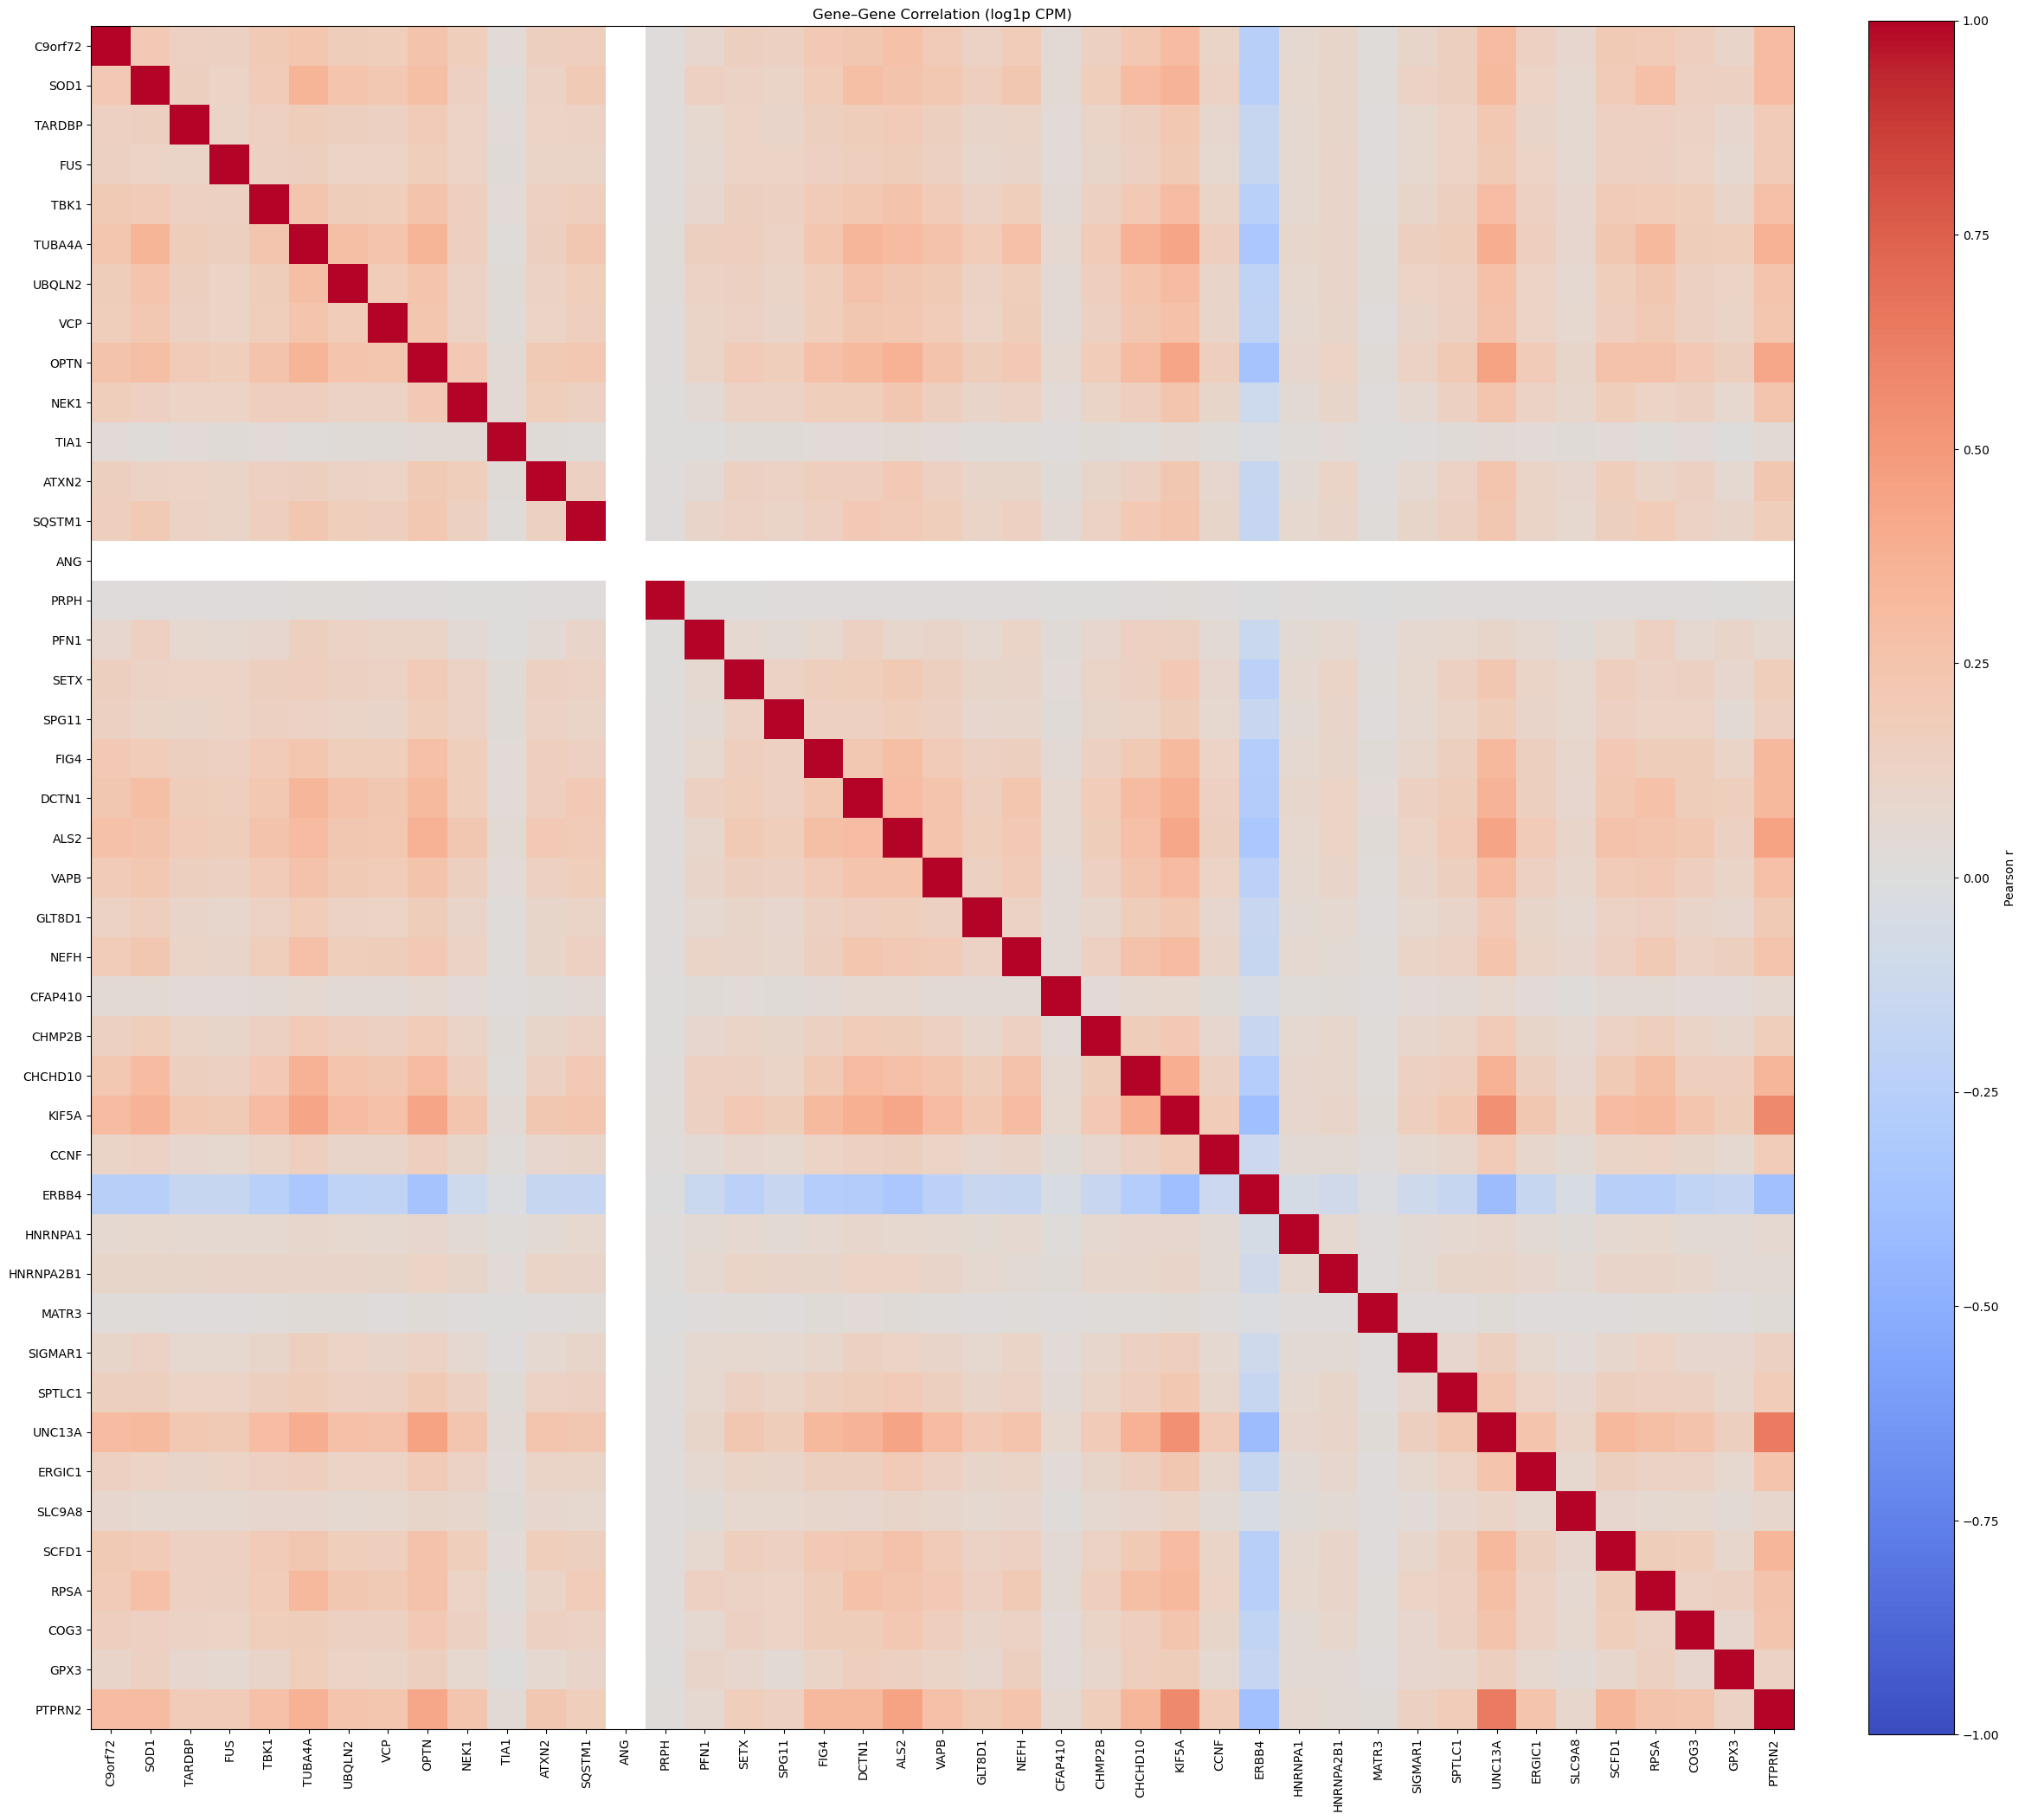

Top single-gene candidates: ['KIF5A', 'UNC13A', 'PTPRN2', 'OPTN', 'TUBA4A', 'ALS2', 'DCTN1', 'CHCHD10', 'ERBB4', 'SOD1']
Top dual-gene pairs: [('UNC13A', 'PTPRN2'), ('KIF5A', 'PTPRN2'), ('KIF5A', 'UNC13A'), ('ALS2', 'PTPRN2'), ('OPTN', 'UNC13A'), ('ALS2', 'UNC13A'), ('TUBA4A', 'KIF5A'), ('OPTN', 'KIF5A'), ('OPTN', 'PTPRN2'), ('ALS2', 'KIF5A')]


In [15]:
base = adata

try:
    all_genes
except NameError:
    candidates = list(dict.fromkeys(well_known + top_10 + rare_variants + unknown_effects + common_variants))
    all_genes = [g for g in candidates if g in base.var_names]  
    all_genes = [g for g in candidates if g in base.var_names]

if len(all_genes) < 2:
    raise ValueError("Fewer than 2 requested genes are present.")

def pick_counts_layer(a, names=("raw","counts","raw_counts")):
    for n in names:
        if n in a.layers:
            return a.layers[n]
    return a.X

X_full = pick_counts_layer(base)
if hasattr(X_full, "toarray"):
    X_full = X_full.toarray()
X = X_full[:, base.var_names.get_indexer(all_genes)]
lib = X.sum(axis=1, keepdims=True)
lib[lib == 0] = 1
X_cpm = X / lib * 1e4
X_log = np.log1p(X_cpm)

C = np.corrcoef(X_log, rowvar=False)
corr_df = pd.DataFrame(C, index=all_genes, columns=all_genes)
corr_df.to_csv("gene_corr_matrix.csv")

C_abs = np.abs(C)
np.fill_diagonal(C_abs, np.nan)
mean_abs = np.nanmean(C_abs, axis=0)
rank_df = pd.DataFrame({"gene": all_genes, "mean_abs_corr": mean_abs}).sort_values("mean_abs_corr", ascending=False)
rank_df.to_csv("gene_corr_ranking.csv", index=False)

pairs = []
n = len(all_genes)
for i in range(n):
    for j in range(i+1, n):
        pairs.append((all_genes[i], all_genes[j], C_abs[i, j]))
pairs_df = pd.DataFrame(pairs, columns=["gene_i","gene_j","abs_corr"]).sort_values("abs_corr", ascending=False)
pairs_df.head(25).to_csv("gene_corr_top_pairs.csv", index=False)

plt.figure(figsize=(0.5*len(all_genes)+2, 0.5*len(all_genes)+2))
im = plt.imshow(C, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(ticks=np.arange(n), labels=all_genes, rotation=90)
plt.yticks(ticks=np.arange(n), labels=all_genes)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Pearson r")
plt.title("Gene–Gene Correlation (log1p CPM)")
plt.tight_layout()
plt.savefig("gene_corr_heatmap.png", dpi=200)
plt.show()

top_single = rank_df["gene"].head(10).tolist()
top_pairs = pairs_df.head(10)[["gene_i","gene_j"]].apply(lambda r: (r["gene_i"], r["gene_j"]), axis=1).tolist()

print("Top single-gene candidates:", top_single)
print("Top dual-gene pairs:", top_pairs)

## Perturbation experiment 

We can test both up- and down-regulation perturbations for both `ALS` and `PN` cells, using the following sets of genes, or we can try perturbing individual genes:
- `well_known`
- `top_10`
- `rare_variants`
- `unknown_effects`
- `common_variants`
- `all_genes`

**Note**: I think we can additionally probe `unknown_effects` to see if their embeddings come close to any other genes' embeddings, which may help in getting some mechanistic insight into those genes. 

## Perturbing individual genes

In addition to perturbing individual genes - which makes finding candidates easier - my pipeline can also be used to perturb multiple genes at once. To demonstrate this, I will now attempt to do the following:

- Perturb **_C9orf72_** individually and see if their embeddings go close to the disease state, or the healthy state. 
- Perturb **_C9orf72_** and **_KIF5A_** and see how the embeddings shift - I selected _KIF5A_ based on the heatmap since it shows the highest mean correlation with all other genes. 

At this point, we will only focus on perturbing this for `ALS` cells, but we can always use the function to perturb control cells as well. 

### Perturbing _C9orf72_

In [16]:
C9orf72_ALS_up = simulate_perturbation(path = "/Users/ali/Downloads/counts_combined_filtered_BA4_sALS_PN.h5ad",
                                       genes = ["C9orf72"], 
                                       mode="up", 
                                       fold_change=4.0, 
                                       frac_cells=1.0,
                                       by_group_key="Condition", 
                                       group_values=["ALS"])

C9orf72_ALS_down = simulate_perturbation(path = "/Users/ali/Downloads/counts_combined_filtered_BA4_sALS_PN.h5ad",
                                       genes = ["C9orf72"], 
                                       mode="down", 
                                       fold_change=4.0, 
                                       frac_cells=1.0,
                                       by_group_key="Condition", 
                                       group_values=["ALS"])

Simulating up regulation of ['C9orf72'] in 100.0% of cells
Loading data from: /Users/ali/Downloads/counts_combined_filtered_BA4_sALS_PN.h5ad
Finished simulation for ['C9orf72'] in 100.0% of cells
Returning modified AnnData object
Simulating down regulation of ['C9orf72'] in 100.0% of cells
Loading data from: /Users/ali/Downloads/counts_combined_filtered_BA4_sALS_PN.h5ad
Finished simulation for ['C9orf72'] in 100.0% of cells
Returning modified AnnData object


### Perturbing _C9orf72_ and _KIF5A_

In [17]:
dual_perturb_ALS_up = simulate_perturbation(path = "/Users/ali/Downloads/counts_combined_filtered_BA4_sALS_PN.h5ad",
                                       genes = ["C9orf72", "KIF5A"], 
                                       mode="up", 
                                       fold_change=4.0, 
                                       frac_cells=1.0,
                                       by_group_key="Condition", 
                                       group_values=["ALS"])

dual_perturb_ALS_down = simulate_perturbation(path = "/Users/ali/Downloads/counts_combined_filtered_BA4_sALS_PN.h5ad",
                                            genes = ["C9orf72", "KIF5A"], 
                                            mode="down", 
                                            fold_change=4.0, 
                                            frac_cells=1.0,
                                            by_group_key="Condition", 
                                            group_values=["ALS"])

Simulating up regulation of ['C9orf72', 'KIF5A'] in 100.0% of cells
Loading data from: /Users/ali/Downloads/counts_combined_filtered_BA4_sALS_PN.h5ad
Finished simulation for ['C9orf72', 'KIF5A'] in 100.0% of cells
Returning modified AnnData object
Simulating down regulation of ['C9orf72', 'KIF5A'] in 100.0% of cells
Loading data from: /Users/ali/Downloads/counts_combined_filtered_BA4_sALS_PN.h5ad
Finished simulation for ['C9orf72', 'KIF5A'] in 100.0% of cells
Returning modified AnnData object


## Subsetting the dataset

Now, to speed up-processing (without a GPU), we will subset the dataset by first finding all the cells that are common between the perturbed datasets, and then taking 5,000 cells from that intersection. 

In [21]:
common = adata.obs_names.intersection(C9orf72_ALS_up.obs_names)\
                         .intersection(C9orf72_ALS_down.obs_names)\
                         .intersection(dual_perturb_ALS_up.obs_names)\
                         .intersection(dual_perturb_ALS_down.obs_names)

subset_size = len(common) #You can change this value to select a different number of cells

sel = np.random.default_rng(0).choice(common, size=min(subset_size, len(common)), replace=False)

adata[sel].write_h5ad("adata_base_5k.h5ad", compression="gzip")
C9orf72_ALS_down[sel].write_h5ad("adata_C9orf72_ALS_down_5k.h5ad", compression="gzip")
C9orf72_ALS_up[sel].write_h5ad("adata_C9orf72_ALS_up_5k.h5ad", compression="gzip")
dual_perturb_ALS_up[sel].write_h5ad("adata_dual_perturb_ALS_up_5k.h5ad", compression="gzip")
dual_perturb_ALS_down[sel].write_h5ad("adata_dual_perturb_ALS_down_5k.h5ad", compression="gzip")

/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [22]:
print(" Full data shape:", adata.shape)

print("\n Subset data shape:", adata.shape, "\n",
      "Subset C9orf72_ALS_down:", C9orf72_ALS_down.shape, "\n",
      "Subset C9orf72_ALS_up:", C9orf72_ALS_up.shape, "\n", 
      "Subset dual_perturb_ALS_up:", dual_perturb_ALS_up.shape, "\n",
      "Subset dual_perturb_ALS_down:", dual_perturb_ALS_down.shape)

 Full data shape: (112014, 22832)

 Subset data shape: (112014, 22832) 
 Subset C9orf72_ALS_down: (112014, 22832) 
 Subset C9orf72_ALS_up: (112014, 22832) 
 Subset dual_perturb_ALS_up: (112014, 22832) 
 Subset dual_perturb_ALS_down: (112014, 22832)
